In [1]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 

import functional_sensitivity_lib as fun_sens_lib
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)


import json

# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

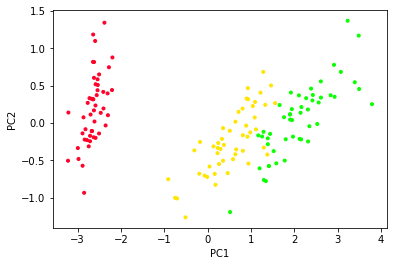

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

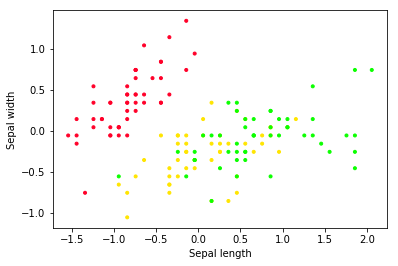

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [10]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [11]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [12]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [13]:
set_truth = False

In [14]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [15]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

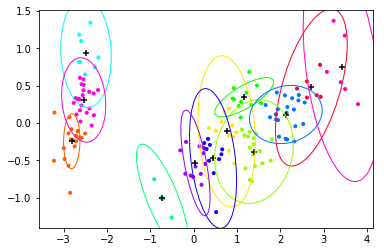

In [16]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [17]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [18]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [19]:
load_from_disc = True

In [20]:
if not load_from_disc: 
    t0 = time.time()
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500)
    t_newton = time.time() - t0

    print('done. ')
    
else: 

    full_data_fit_file = '../iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
    with open(full_data_fit_file, 'r') as fp:
        fit_dict = json.load(fp)

    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)

    best_param = model.global_vb_params.get_free()

In [21]:
newton_results = deepcopy(model)

In [22]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [23]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [24]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

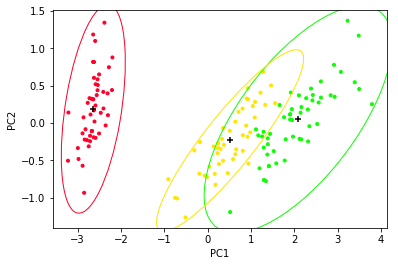

In [25]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [26]:
# plt.scatter(pc_features[bnp_clusters == 0, 0], pc_features[bnp_clusters == 0, 1])

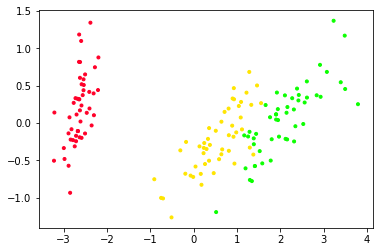

In [27]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

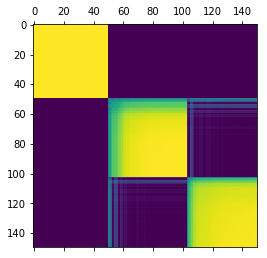

In [28]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [29]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

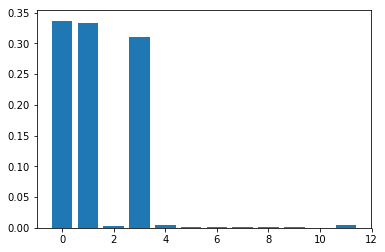

In [30]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

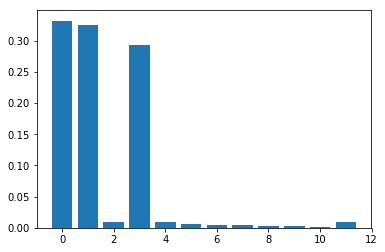

In [31]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  2.,   0.,   1.,   1.,   1.,   5.,   2.,   2.,   6., 130.]),
 array([0.44352936, 0.49917643, 0.55482349, 0.61047055, 0.66611762,
        0.72176468, 0.77741174, 0.83305881, 0.88870587, 0.94435294,
        1.        ]),
 <a list of 10 Patch objects>)

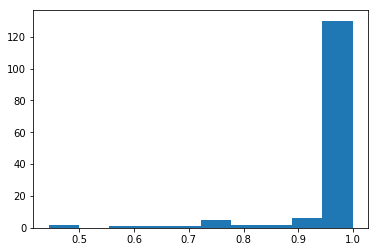

In [32]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Functional sensitivity

In [33]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [34]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [35]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.07230487288465379 2452.4187642002653


In [36]:
# expected number of clusters
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [37]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))

for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

In [38]:
model.set_from_global_free_par(best_param)
e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

for i in range(k_approx): 
    assert np.abs(get_kth_weight_from_free_param(model, best_param, i) - \
                        modeling_lib.get_mixture_weights(e_sticks)[i]) < 1e-12

In [39]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


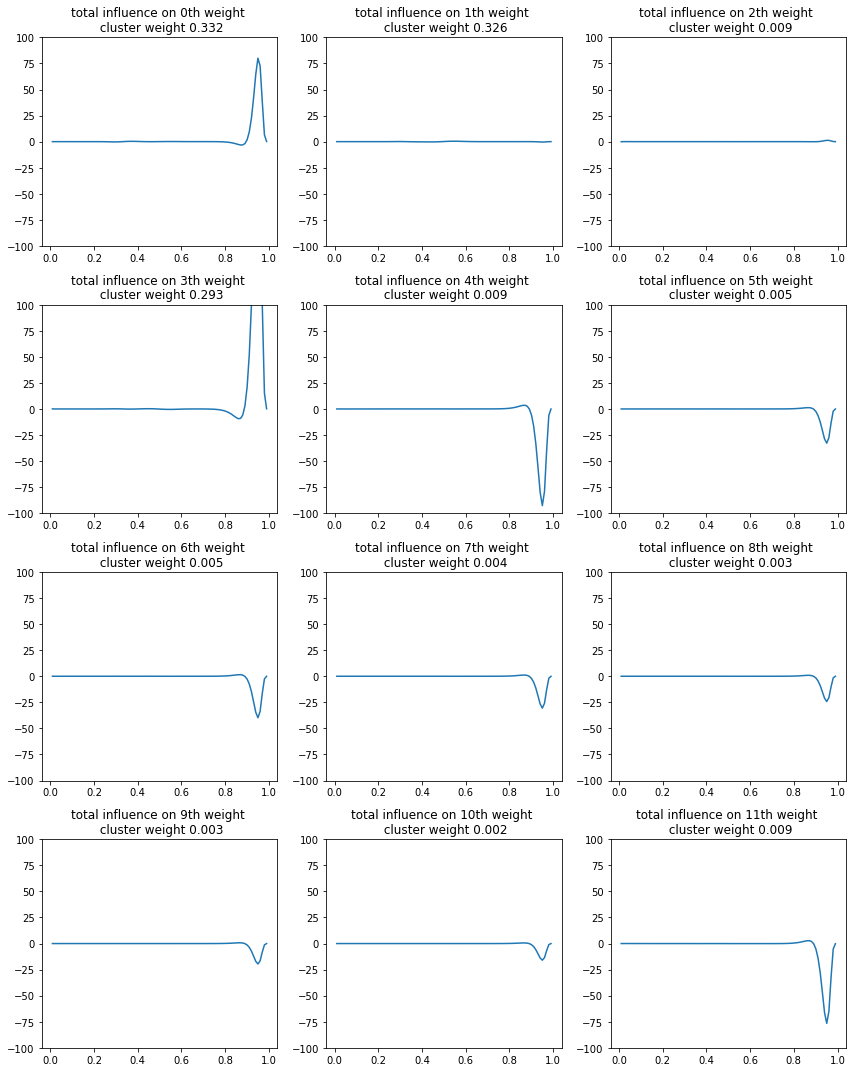

In [40]:
f, axarr = plt.subplots(4, 3, figsize=(12, 15))

for k in range(k_approx): 
    
    indx1 = int(np.floor(k / 3))
    indx2 = k % 3
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('total influence on {}th weight \n cluster weight {}'.format(
        k, round(weights[k], 3)))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

# f.delaxes(axarr[5][1])

f.tight_layout()


In [41]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [42]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

In [43]:
theta = np.linspace(0.01, 0.99, 100)
influence_n_clust = np.zeros((k_approx, len(theta)))

for k in range(k_approx - 1): 
    influence_n_clust[k, :] += np.dot(np.array([g_eta_nclust]), \
                                           linear_sens.influence_function(theta, k)).flatten()


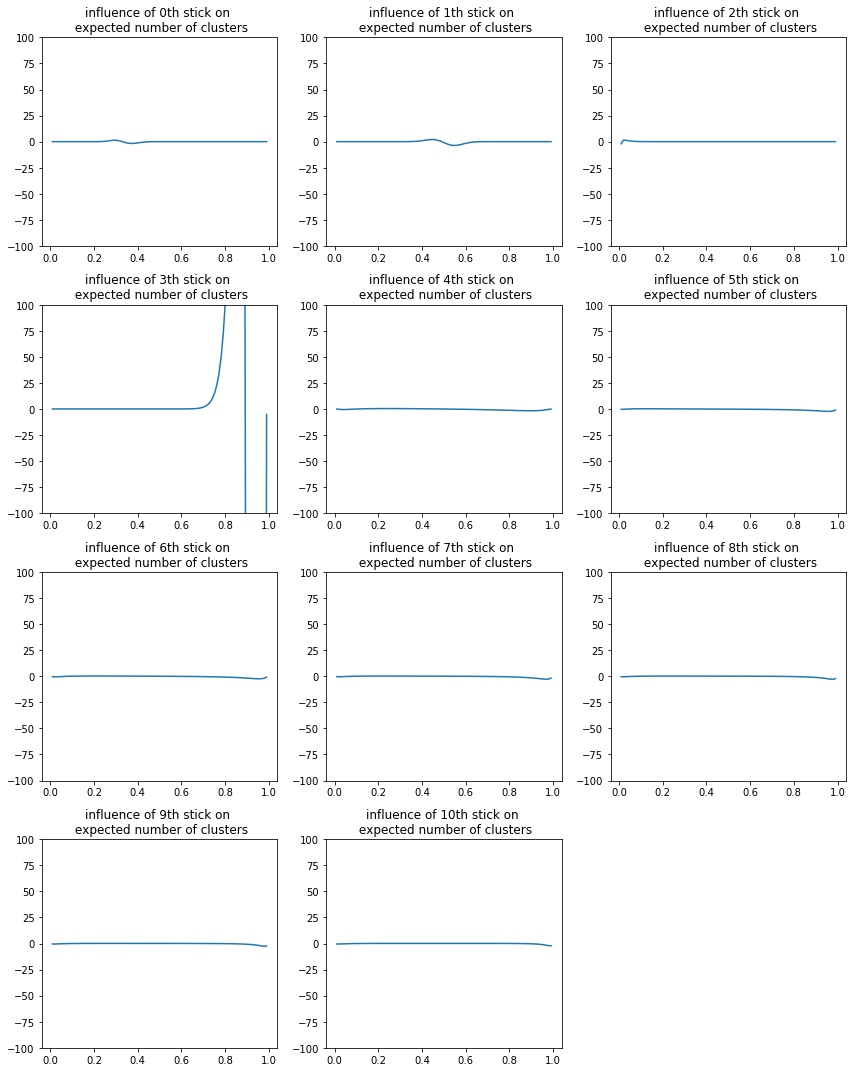

In [44]:
f, axarr = plt.subplots(4, 3, figsize=(12, 15))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 3))
    indx2 = k % 3
    axarr[indx1, indx2].plot(theta, influence_n_clust[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('influence of {}th stick on \n expected number of clusters'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[3][2])

f.tight_layout()


In [45]:
total_influence_n_clust = np.sum(influence_n_clust, axis = 0)

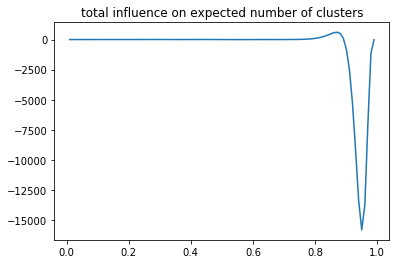

In [46]:
plt.plot(theta, total_influence_n_clust)
plt.title('total influence on expected number of clusters')

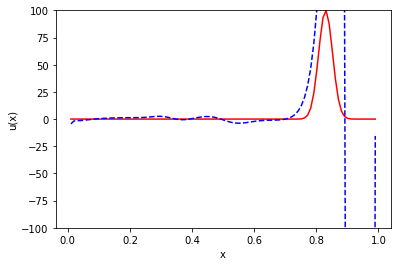

In [47]:
# lets choose a perturbation 
epsilon = 0.002

# u = lambda x : np.exp(-(x - 0.97)**2 / 0.01)
u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100, color = 'red')
plt.plot(theta, total_influence_n_clust, '--', color = 'blue')
plt.ylim((-100, 100))
plt.ylabel('u(x)')
plt.xlabel('x')

In [48]:
# get functional sensitivity
fun_sens_mat = np.zeros((len(best_param), k_approx - 1))
for k in range(k_approx - 1): 
    fun_sens_mat[:, k] = linear_sens.get_functional_sensitivity(lambda x : u(x), k)

In [49]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [50]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.07689133299897
Iter: 10	 RMSE: 9.025151824982384	 Objective: -338.07833356196477
Iter: 20	 RMSE: 9.025177541044219	 Objective: -338.0784329086046
Iter: 30	 RMSE: 9.024336014549922	 Objective: -338.07861828935467
Iter: 40	 RMSE: 9.023692258445799	 Objective: -338.078689290424
Iter: 50	 RMSE: 9.023654457411574	 Objective: -338.07871363173314
Iter: 60	 RMSE: 9.023674233169269	 Objective: -338.0787206084884
Iter: 70	 RMSE: 9.023674605854506	 Objective: -338.07872090655036
Optimization terminated successfully.
         Current function value: -338.078721
         Iterations: 62
         Function evaluations: 80
         Gradient evaluations: 80
Iter: 80	 RMSE: 9.023674186635288	 Objective: -338.07872091771844
         Current function value: -338.078721
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0001410072583208756, f_diff = 1.1220890883123502e-1

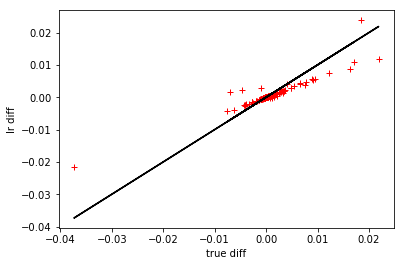

In [51]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, epsilon * np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


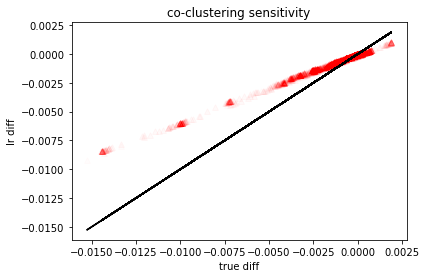

In [52]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


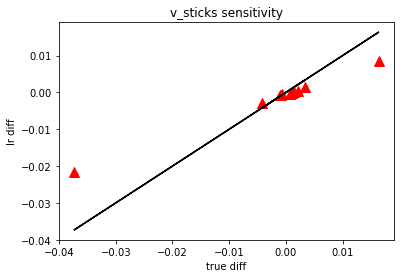

In [53]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


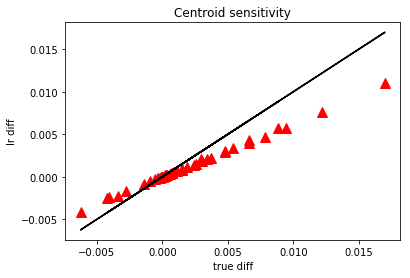

In [54]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [55]:
get_e_number_clusters_from_free_par(model, best_param)

6.299481890674361

In [56]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

perturbed e_number_clusters: 6.350664737224467


In [57]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 6.321784659956682


In [101]:
# Test this perturbation for a range of epsilons

In [64]:
epsilons = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# epsilons = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02]
# epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]

In [65]:
pert_opt_free_param_list = []

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : u(x) * epsilons[i])
    
    pert_opt_free_param_list.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/16 [00:00<?, ?it/s]

optimizing when epsilon = 0.001
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.06268881168364
Iter: 10	 RMSE: 9.026541029454155	 Objective: -338.06306726533103
Iter: 20	 RMSE: 9.026560777714693	 Objective: -338.06309343873113
Iter: 30	 RMSE: 9.026180657144515	 Objective: -338.0631421349153
Iter: 40	 RMSE: 9.025897953468949	 Objective: -338.06316397093116
Iter: 50	 RMSE: 9.02577511010168	 Objective: -338.0631688867472
Iter: 60	 RMSE: 9.025796792955587	 Objective: -338.0631698659843
Iter: 70	 RMSE: 9.025797236619171	 Objective: -338.06316990021145
Optimization terminated successfully.
         Current function value: -338.063170
         Iterations: 62
         Function evaluations: 74
         Gradient evaluations: 74


  6%|▋         | 1/16 [00:17<04:18, 17.26s/it]

         Current function value: -338.063170
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00013245261831693763, f_diff = 7.673861546209082e-11
optimizing when epsilon = 0.0025
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0838379567522
Iter: 10	 RMSE: 9.024516299904352	 Objective: -338.08602697492245
Iter: 20	 RMSE: 9.024539331734303	 Objective: -338.0861770779286
Iter: 30	 RMSE: 9.023488681082428	 Objective: -338.08645579757854
Iter: 40	 RMSE: 9.023014372786022	 Objective: -338.08656961373913
Iter: 50	 RMSE: 9.022691709335428	 Objective: -338.08660219412855
Iter: 60	 RMSE: 9.022710724520163	 Objective: -338.08660924202934
Iter: 70	 RMSE: 9.022687916762864	 Objective: -338.0866096689269
Optimization terminated successfully.
         Current function value: -338.086610
         Iterations: 62
         Function evaluations: 79
         Gradient evaluations: 79
Iter: 80	 RMSE: 9.022691858364

 12%|█▎        | 2/16 [00:30<03:32, 15.19s/it]

         Current function value: -338.086610
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00013580368834777455, f_diff = 8.554934538551606e-11
optimizing when epsilon = 0.005
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.1171456550779
Iter: 10	 RMSE: 9.022073604151364	 Objective: -338.1244553155621
Iter: 20	 RMSE: 9.022032990148967	 Objective: -338.12495871868293
Iter: 30	 RMSE: 9.020029445519416	 Objective: -338.1258518321605
Iter: 40	 RMSE: 9.018685187138662	 Objective: -338.1247942939976
Iter: 50	 RMSE: 9.018805899626242	 Objective: -338.1263145457401
Iter: 60	 RMSE: 9.018778071474658	 Objective: -338.1263274280826
Iter: 70	 RMSE: 9.018784163960866	 Objective: -338.12632780664904
Optimization terminated successfully.
         Current function value: -338.126328
         Iterations: 65
         Function evaluations: 80
         Gradient evaluations: 80
Iter: 80	 RMSE: 9.018788273217194	

 19%|█▉        | 3/16 [00:45<03:18, 15.26s/it]

         Current function value: -338.126328
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 9.484920747595215e-05, f_diff = 8.282086128019728e-11
optimizing when epsilon = 0.0075
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.14831709802877
Iter: 10	 RMSE: 9.020621432456855	 Objective: -338.1616570318944
Iter: 20	 RMSE: 9.020460682858024	 Objective: -338.16267584726586
Iter: 30	 RMSE: 9.016522368645406	 Objective: -338.1642573586038
Iter: 40	 RMSE: 9.01615438425959	 Objective: -338.163799501292
Iter: 50	 RMSE: 9.016284178858097	 Objective: -338.1651562511772
Iter: 60	 RMSE: 9.01617413775797	 Objective: -338.16517364166697
Iter: 70	 RMSE: 9.016206707611191	 Objective: -338.16517514693936
Iter: 80	 RMSE: 9.016204732410563	 Objective: -338.16517516411176
Optimization terminated successfully.
         Current function value: -338.165175
         Iterations: 66
         Function evaluations: 83
   

 25%|██▌       | 4/16 [01:12<03:38, 18.21s/it]

         Current function value: -338.165175
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00012275695363699713, f_diff = 7.361222742474638e-11
optimizing when epsilon = 0.01
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.17762747784934
Iter: 10	 RMSE: 9.019681430485067	 Objective: -338.1968709223195
Iter: 20	 RMSE: 9.019395573163393	 Objective: -338.19858012353467
Iter: 30	 RMSE: 9.01511540809894	 Objective: -338.2011140404571
Iter: 40	 RMSE: 9.014709495612951	 Objective: -338.2011916504066
Iter: 50	 RMSE: 9.014452485050775	 Objective: -338.2023391683105
Iter: 60	 RMSE: 9.01433678783825	 Objective: -338.20236426547336
Iter: 70	 RMSE: 9.014334332021212	 Objective: -338.20236601464626
Iter: 80	 RMSE: 9.014331092429323	 Objective: -338.20236608451717
Optimization terminated successfully.
         Current function value: -338.202366
         Iterations: 69
         Function evaluations: 87
   

 31%|███▏      | 5/16 [01:31<03:20, 18.27s/it]

         Current function value: -338.202366
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.0812242093251385e-05, f_diff = 2.0122570276726037e-11
optimizing when epsilon = 0.0125
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.2053011719119
Iter: 10	 RMSE: 9.019021319693865	 Objective: -338.2299549584524
Iter: 20	 RMSE: 9.018613467203611	 Objective: -338.2325292912984
Iter: 30	 RMSE: 9.014127999604765	 Objective: -338.2360542521403
Iter: 40	 RMSE: 9.013443039033033	 Objective: -338.23743096671114
Iter: 50	 RMSE: 9.012879169228233	 Objective: -338.23773804392533
Iter: 60	 RMSE: 9.012769441020708	 Objective: -338.23777509645004
Iter: 70	 RMSE: 9.012807616755724	 Objective: -338.2377771277004
Iter: 80	 RMSE: 9.012804291608086	 Objective: -338.23777717025723
Optimization terminated successfully.
         Current function value: -338.237777
         Iterations: 68
         Function evaluations: 85

 38%|███▊      | 6/16 [01:48<03:00, 18.06s/it]

         Current function value: -338.237777
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 7.099980902781694e-05, f_diff = 4.5076831156620756e-11
optimizing when epsilon = 0.015
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.23152360162425
Iter: 10	 RMSE: 9.018489904505728	 Objective: -338.26110104883224
Iter: 20	 RMSE: 9.01798235038887	 Objective: -338.26464050377876
Iter: 30	 RMSE: 9.013173002606532	 Objective: -338.2692960298281
Iter: 40	 RMSE: 9.012188972300594	 Objective: -338.27104900789135
Iter: 50	 RMSE: 9.011558403872447	 Objective: -338.2714828659806
Iter: 60	 RMSE: 9.011465137753913	 Objective: -338.2715151933833
Iter: 70	 RMSE: 9.011444234351025	 Objective: -338.2715197008761
Iter: 80	 RMSE: 9.01143700157582	 Objective: -338.2715197897537
Optimization terminated successfully.
         Current function value: -338.271520
         Iterations: 68
         Function evaluations: 86
   

 44%|████▍     | 7/16 [02:02<02:37, 17.48s/it]

         Current function value: -338.271520
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00010709839764299402, f_diff = 7.042899596854113e-11
optimizing when epsilon = 0.0175
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.2564498140876
Iter: 10	 RMSE: 9.017891655636872	 Objective: -338.2909615185833
Iter: 20	 RMSE: 9.017379962946547	 Objective: -338.29523936458696
Iter: 30	 RMSE: 9.012244007956037	 Objective: -338.30101300428544
Iter: 40	 RMSE: 9.010340075438647	 Objective: -338.30344881520824
Iter: 50	 RMSE: 9.010139395495038	 Objective: -338.3037094043944
Iter: 60	 RMSE: 9.010121972427143	 Objective: -338.30377882710604
Iter: 70	 RMSE: 9.010109987968873	 Objective: -338.3037818663268
Iter: 80	 RMSE: 9.010101147935611	 Objective: -338.303781915723
Optimization terminated successfully.
         Current function value: -338.303782
         Iterations: 67
         Function evaluations: 88
 

 50%|█████     | 8/16 [02:16<02:16, 17.07s/it]

Iter: 90	 RMSE: 9.010103593167573	 Objective: -338.30378191710685
         Current function value: -338.303782
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00012136809021714683, f_diff = 6.252776074688882e-11
optimizing when epsilon = 0.02
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.28021081767224
Iter: 10	 RMSE: 9.017229603558256	 Objective: -338.3197593913759
Iter: 20	 RMSE: 9.016786048665779	 Objective: -338.3245220367857
Iter: 30	 RMSE: 9.011361810425402	 Objective: -338.3313466444589
Iter: 40	 RMSE: 9.009004222552003	 Objective: -338.3343871409194
Iter: 50	 RMSE: 9.008692080757326	 Objective: -338.33468661991213
Iter: 60	 RMSE: 9.008742422783467	 Objective: -338.3347625314925
Iter: 70	 RMSE: 9.008706941528361	 Objective: -338.3347657703448
Iter: 80	 RMSE: 9.00869984867347	 Objective: -338.3347658222787
Optimization terminated successfully.
         Current function value: -338.3347

 56%|█████▋    | 9/16 [02:35<02:01, 17.32s/it]

         Current function value: -338.334766
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00014763241368905225, f_diff = 9.464429240324534e-11
optimizing when epsilon = 0.0225
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.302918342768
Iter: 10	 RMSE: 9.016516289346201	 Objective: -338.3475358789518
Iter: 20	 RMSE: 9.016186040611055	 Objective: -338.35262058113176
Iter: 30	 RMSE: 9.010483706854545	 Objective: -338.36042465805394
Iter: 40	 RMSE: 9.00760603915521	 Objective: -338.3642173913027
Iter: 50	 RMSE: 9.007134228609676	 Objective: -338.3645823787513
Iter: 60	 RMSE: 9.007196802040518	 Objective: -338.3646702873026
Iter: 70	 RMSE: 9.00716618278706	 Objective: -338.36467416047594
Iter: 80	 RMSE: 9.007164040523328	 Objective: -338.36467421226007
Optimization terminated successfully.
         Current function value: -338.364674
         Iterations: 66
         Function evaluations: 86
   

 62%|██████▎   | 10/16 [02:49<01:41, 16.98s/it]

         Current function value: -338.364674
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00015211149712303132, f_diff = 9.777068044058979e-11
optimizing when epsilon = 0.05
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.50368921496886
Iter: 10	 RMSE: 9.01093770990449	 Objective: -338.5902725795635
Iter: 20	 RMSE: 9.010723219386215	 Objective: -338.60508508242896
Iter: 30	 RMSE: 8.995867677626288	 Objective: -338.6390420324707
Iter: 40	 RMSE: 8.992721047273283	 Objective: -338.65802932483695
Iter: 50	 RMSE: 8.989980625188673	 Objective: -338.66218126893
Iter: 60	 RMSE: 8.990256270309288	 Objective: -338.6626348963752
Iter: 70	 RMSE: 8.990254060042355	 Objective: -338.6626491105565
Iter: 80	 RMSE: 8.990265419545759	 Objective: -338.66264944454866
Optimization terminated successfully.
         Current function value: -338.662649
         Iterations: 70
         Function evaluations: 89
     

 69%|██████▉   | 11/16 [03:03<01:23, 16.70s/it]

         Current function value: -338.662649
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 9.918023836405482e-05, f_diff = 7.51469997339882e-11
optimizing when epsilon = 0.1
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.7472134049374
Iter: 10	 RMSE: 9.005591251179458	 Objective: -338.8882226092165
Iter: 20	 RMSE: 9.001087928009087	 Objective: -338.9387514340057
Iter: 30	 RMSE: 8.985313757013824	 Objective: -339.0276690221384
Iter: 40	 RMSE: 8.986949946777099	 Objective: -339.06942837322214
Iter: 50	 RMSE: 8.983577010638088	 Objective: -339.092133062062
Iter: 60	 RMSE: 8.983409919505249	 Objective: -339.0923602895484
Iter: 70	 RMSE: 8.983344280576699	 Objective: -339.0923747823524
Iter: 80	 RMSE: 8.983362786134702	 Objective: -339.092375285191
Optimization terminated successfully.
         Current function value: -339.092375
         Iterations: 70
         Function evaluations: 88
         G

 75%|███████▌  | 12/16 [03:21<01:07, 16.76s/it]

Iter: 90	 RMSE: 8.983362371301856	 Objective: -339.0923752889493
         Current function value: -339.092375
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00010805957155720624, f_diff = 8.571987564209849e-11
optimizing when epsilon = 0.15
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.91881828140686
Iter: 10	 RMSE: 8.998420972060384	 Objective: -339.1197316141145
Iter: 20	 RMSE: 8.997087246515756	 Objective: -339.1626712836131
Iter: 30	 RMSE: 8.987054792988062	 Objective: -339.3057256701292
Iter: 40	 RMSE: 8.985387097997457	 Objective: -339.40150302499376
Iter: 50	 RMSE: 8.981780623258393	 Objective: -339.40857742212825
Iter: 60	 RMSE: 8.98205234763281	 Objective: -339.40910655857374
Iter: 70	 RMSE: 8.981958621399775	 Objective: -339.4091234204898
Iter: 80	 RMSE: 8.981974441741635	 Objective: -339.40912435462803
Iter: 90	 RMSE: 8.981973437930142	 Objective: -339.40912437226484
Optimization

 81%|████████▏ | 13/16 [03:35<00:49, 16.60s/it]

         Current function value: -339.409124
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00020145949352267238, f_diff = 2.2038193492335267e-10
optimizing when epsilon = 0.2
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.05302241147825
Iter: 10	 RMSE: 8.994321974891756	 Objective: -339.30183352079194
Iter: 20	 RMSE: 8.99575982268453	 Objective: -339.3546409814071
Iter: 30	 RMSE: 8.98389127366625	 Objective: -339.5366509907474
Iter: 40	 RMSE: 8.983897217441879	 Objective: -339.63312991657995
Iter: 50	 RMSE: 8.98177395916709	 Objective: -339.65366034323563
Iter: 60	 RMSE: 8.98085231467425	 Objective: -339.6558722793093
Iter: 70	 RMSE: 8.980757018544248	 Objective: -339.6558892053609
Iter: 80	 RMSE: 8.980780157445293	 Objective: -339.6558900183434
Iter: 90	 RMSE: 8.980773776246108	 Objective: -339.65589004529517
Optimization terminated successfully.
         Current function value: -339.65589

 88%|████████▊ | 14/16 [03:49<00:32, 16.42s/it]

         Current function value: -339.655890
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00016325123509473727, f_diff = 1.361399881716352e-10
optimizing when epsilon = 0.25
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.1640376653028
Iter: 10	 RMSE: 8.993892513493048	 Objective: -339.446803171038
Iter: 20	 RMSE: 8.993813359435114	 Objective: -339.53497962942953
Iter: 30	 RMSE: 8.979427191921234	 Objective: -339.7677423661778
Iter: 40	 RMSE: 8.98346765699885	 Objective: -339.8487699885062
Iter: 50	 RMSE: 8.980828758848151	 Objective: -339.8563620583452
Iter: 60	 RMSE: 8.980035517589544	 Objective: -339.85653809312674
Iter: 70	 RMSE: 8.980100398859172	 Objective: -339.8565416218824
Iter: 80	 RMSE: 8.980078157943582	 Objective: -339.8565418240224
Optimization terminated successfully.
         Current function value: -339.856542
         Iterations: 74
         Function evaluations: 90
      

 94%|█████████▍| 15/16 [04:07<00:16, 16.48s/it]

         Current function value: -339.856542
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00010108630179487646, f_diff = 4.8203219193965197e-11
optimizing when epsilon = 0.3
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.2591684232212
Iter: 10	 RMSE: 8.99393094030715	 Objective: -339.5711302029906
Iter: 20	 RMSE: 8.994636960185495	 Objective: -339.673868534628
Iter: 30	 RMSE: 8.977412704637567	 Objective: -339.94852962535737
Iter: 40	 RMSE: 8.982656211360851	 Objective: -340.0195372589229
Iter: 50	 RMSE: 8.980140779195168	 Objective: -340.0251850897153
Iter: 60	 RMSE: 8.979587474874396	 Objective: -340.0253587407556
Iter: 70	 RMSE: 8.979643767610552	 Objective: -340.02536536036945
Iter: 80	 RMSE: 8.979639802279417	 Objective: -340.02536566749774
Iter: 90	 RMSE: 8.979639079770116	 Objective: -340.0253656702897
Optimization terminated successfully.
         Current function value: -340.02536

100%|██████████| 16/16 [04:18<00:00, 16.18s/it]

Optimization terminated successfully.
         Current function value: -340.025366
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 9.04129497207114e-05, f_diff = 4.376943252282217e-11


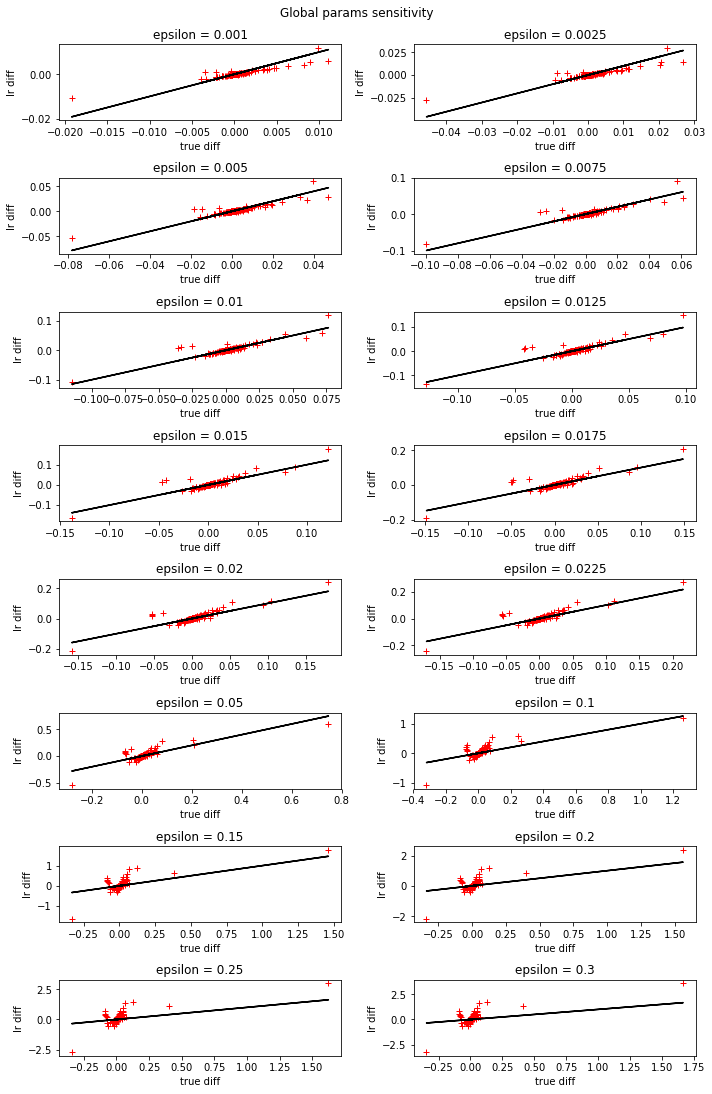

In [66]:
# check global params

# linear_sens.moment_model.set_moments_from_free_par(best_param)

# fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x))

f, axarr = plt.subplots(int(len(epsilons) / 2), 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


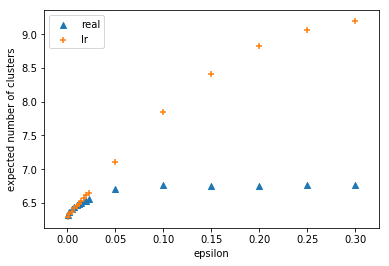

In [68]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('real', 'lr'))
# plt.xlim((0.0, 0.026))

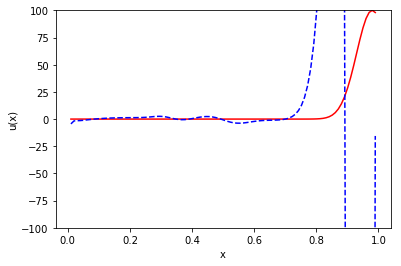

In [69]:
# lets choose a perturbation 
epsilon = 0.0001

u = lambda x : np.exp(-(x - 0.98)**2 / 0.005)
# u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100, color = 'red')
plt.plot(theta, total_influence_n_clust, '--', color = 'blue')
plt.ylim((-100, 100))
plt.xlabel('x')
plt.ylabel('u(x)')

In [70]:
# get functional sensitivity
fun_sens_mat = np.zeros((len(best_param), k_approx - 1))
for k in range(k_approx - 1): 
    fun_sens_mat[:, k] = linear_sens.get_functional_sensitivity(lambda x : u(x), k)

In [71]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [72]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0654536924742
Iter: 10	 RMSE: 9.030567074109795	 Objective: -338.06639033188907
Iter: 20	 RMSE: 9.030803174323013	 Objective: -338.06675068248535
Iter: 30	 RMSE: 9.03235175011843	 Objective: -338.0672717294082
Iter: 40	 RMSE: 9.03253722211533	 Objective: -338.06738989474377
Iter: 50	 RMSE: 9.032662691641251	 Objective: -338.0674346550174
Iter: 60	 RMSE: 9.032748455534179	 Objective: -338.06744271015197
Iter: 70	 RMSE: 9.032738993883152	 Objective: -338.0674430670741
Iter: 80	 RMSE: 9.032741250235887	 Objective: -338.0674430808581
Optimization terminated successfully.
         Current function value: -338.067443
         Iterations: 68
         Function evaluations: 83
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: -338.067443
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.434974272981654e

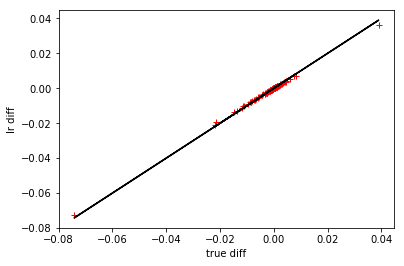

In [73]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, epsilon * np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


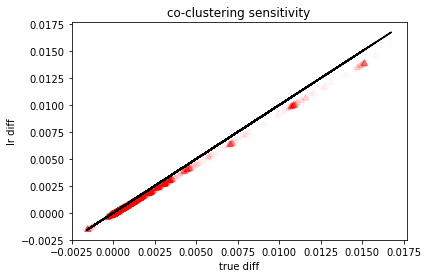

In [74]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


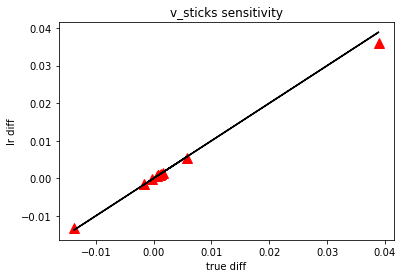

In [75]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


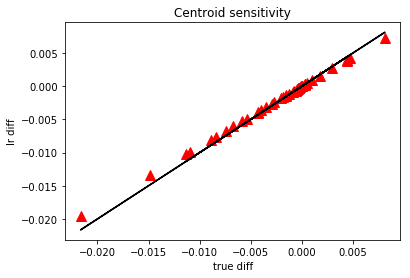

In [76]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [77]:
get_e_number_clusters_from_free_par(model, best_param)

6.297801255041529

In [78]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

perturbed e_number_clusters: 6.229491944434241


In [79]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 6.244738064221515


In [80]:
# Test this perturbation for a range of epsilons

In [81]:
epsilons = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]

In [82]:
pert_opt_free_param_list2 = []

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : u(x) * epsilons[i])
    
    pert_opt_free_param_list2.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/10 [00:00<?, ?it/s]

optimizing when epsilon = 5e-05
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0570310664953
Iter: 10	 RMSE: 9.029308520874483	 Objective: -338.05728114638714
Iter: 20	 RMSE: 9.029408636644192	 Objective: -338.0573757146089
Iter: 30	 RMSE: 9.03005837908349	 Objective: -338.0575048253761
Iter: 40	 RMSE: 9.03009079369082	 Objective: -338.05752684663474
Iter: 50	 RMSE: 9.030279197459144	 Objective: -338.05753903555996
Iter: 60	 RMSE: 9.030301885984235	 Objective: -338.05754122958797
Iter: 70	 RMSE: 9.03029306786806	 Objective: -338.0575413265438
Optimization terminated successfully.
         Current function value: -338.057541
         Iterations: 63
         Function evaluations: 79
         Gradient evaluations: 79
Iter: 80	 RMSE: 9.030295086100136	 Objective: -338.0575413298969


 10%|█         | 1/10 [00:16<02:32, 16.98s/it]

         Current function value: -338.057541
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 9.845501868342569e-05, f_diff = 7.224798537208699e-11
optimizing when epsilon = 0.0001
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0654536924742
Iter: 10	 RMSE: 9.030567074109795	 Objective: -338.06639033188907
Iter: 20	 RMSE: 9.030803174323013	 Objective: -338.06675068248535
Iter: 30	 RMSE: 9.03235175011843	 Objective: -338.0672717294082
Iter: 40	 RMSE: 9.03253722211533	 Objective: -338.06738989474377
Iter: 50	 RMSE: 9.032662691641251	 Objective: -338.0674346550174
Iter: 60	 RMSE: 9.032748455534179	 Objective: -338.06744271015197
Iter: 70	 RMSE: 9.032738993883152	 Objective: -338.0674430670741
Iter: 80	 RMSE: 9.032741250235887	 Objective: -338.0674430808581
Optimization terminated successfully.
         Current function value: -338.067443
         Iterations: 68
         Function evaluations: 83
   

 20%|██        | 2/10 [00:29<01:59, 14.95s/it]

Optimization terminated successfully.
         Current function value: -338.067443
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.434974272981654e-05, f_diff = 1.830358087318018e-11
optimizing when epsilon = 0.00015
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.07344908638015
Iter: 10	 RMSE: 9.03181027655166	 Objective: -338.075450821263
Iter: 20	 RMSE: 9.032209708517684	 Objective: -338.07623710268007
Iter: 30	 RMSE: 9.034784739076569	 Objective: -338.0773471849207
Iter: 40	 RMSE: 9.035108753597815	 Objective: -338.0776161996812
Iter: 50	 RMSE: 9.035351316290294	 Objective: -338.07786332988866
Iter: 60	 RMSE: 9.035458311543925	 Objective: -338.0778822074238
Iter: 70	 RMSE: 9.035415463571123	 Objective: -338.0778835270428
Iter: 80	 RMSE: 9.03541869950628	 Objective: -338.07788358775514
Optimization terminated successfully.
         Current function value: -338.077884
         Iterations: 68

 30%|███       | 3/10 [00:42<01:38, 14.03s/it]

         Current function value: -338.077884
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 6.567494763161204e-05, f_diff = 3.529976311256178e-11
optimizing when epsilon = 0.0002
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0810937062234
Iter: 10	 RMSE: 9.033050812880816	 Objective: -338.0845058818454
Iter: 20	 RMSE: 9.033639343427051	 Objective: -338.0858748703937
Iter: 30	 RMSE: 9.037342767516542	 Objective: -338.08791500564377
Iter: 40	 RMSE: 9.037799858569699	 Objective: -338.0888355123583
Iter: 50	 RMSE: 9.03808011121671	 Objective: -338.0889408228331
Iter: 60	 RMSE: 9.038467305540262	 Objective: -338.0889964562817
Iter: 70	 RMSE: 9.038398144695693	 Objective: -338.08900468606
Iter: 80	 RMSE: 9.038412017852961	 Objective: -338.08900478826524
Optimization terminated successfully.
         Current function value: -338.089005
         Iterations: 67
         Function evaluations: 84
      

 40%|████      | 4/10 [00:55<01:23, 13.98s/it]

         Current function value: -338.089005
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00013108238094931843, f_diff = 7.79891706770286e-11
optimizing when epsilon = 0.00025
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0884397685521
Iter: 10	 RMSE: 9.034297112816079	 Objective: -338.0935870115865
Iter: 20	 RMSE: 9.035099936333678	 Objective: -338.09569592092663
Iter: 30	 RMSE: 9.040341828365333	 Objective: -338.0989880500407
Iter: 40	 RMSE: 9.040964919757563	 Objective: -338.10068863520485
Iter: 50	 RMSE: 9.041602229907905	 Objective: -338.10090672934126
Iter: 60	 RMSE: 9.041784507302662	 Objective: -338.1009822082505
Iter: 70	 RMSE: 9.041840736110954	 Objective: -338.1009900630758
Iter: 80	 RMSE: 9.041844862418266	 Objective: -338.1009903590381
Iter: 90	 RMSE: 9.041844425683013	 Objective: -338.1009903617816
Optimization terminated successfully.
         Current function value: -338.1

 50%|█████     | 5/10 [01:07<01:07, 13.53s/it]

Optimization terminated successfully.
         Current function value: -338.100990
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.4869334831803566e-05, f_diff = 1.9667822925839573e-11
optimizing when epsilon = 0.0003
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.0955255803042
Iter: 10	 RMSE: 9.035555491857687	 Objective: -338.1027193238265
Iter: 20	 RMSE: 9.036597764209638	 Objective: -338.10572796030357
Iter: 30	 RMSE: 9.04191120451397	 Objective: -338.1117308625601
Iter: 40	 RMSE: 9.04454385290431	 Objective: -338.1104867221999
Iter: 50	 RMSE: 9.045606344837747	 Objective: -338.1139326226961
Iter: 60	 RMSE: 9.045923518266749	 Objective: -338.1140811235923
Iter: 70	 RMSE: 9.045896233177139	 Objective: -338.11409844373384
Iter: 80	 RMSE: 9.045909277022504	 Objective: -338.11409896052555
Iter: 90	 RMSE: 9.045909628282141	 Objective: -338.11409896359515
Optimization terminated successfully.
 

 60%|██████    | 6/10 [01:20<00:53, 13.50s/it]

         Current function value: -338.114099
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 6.020417294006744e-05, f_diff = 3.660716174636036e-11
optimizing when epsilon = 0.00035
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.10238059798417
Iter: 10	 RMSE: 9.036831204117323	 Objective: -338.1119243092199
Iter: 20	 RMSE: 9.038138411240856	 Objective: -338.1159969123123
Iter: 30	 RMSE: 9.044788765107455	 Objective: -338.12476446527717
Iter: 40	 RMSE: 9.048182303044973	 Objective: -338.1273092125502
Iter: 50	 RMSE: 9.050909668261403	 Objective: -338.1285339981314
Iter: 60	 RMSE: 9.050966418684999	 Objective: -338.1287284114671
Iter: 70	 RMSE: 9.050971352320163	 Objective: -338.1287336725883
Iter: 80	 RMSE: 9.050973338668692	 Objective: -338.12873391774434
Optimization terminated successfully.
         Current function value: -338.128734
         Iterations: 72
         Function evaluations: 86
 

 70%|███████   | 7/10 [01:34<00:40, 13.52s/it]

         Current function value: -338.128734
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.000167959455852783, f_diff = 9.248424248653464e-11
optimizing when epsilon = 0.0004
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.10902826552
Iter: 10	 RMSE: 9.03812904692694	 Objective: -338.1212215584014
Iter: 20	 RMSE: 9.039727467596192	 Objective: -338.1265287208028
Iter: 30	 RMSE: 9.047886020114838	 Objective: -338.13884674228717
Iter: 40	 RMSE: 9.0539614394559	 Objective: -338.1437569289672
Iter: 50	 RMSE: 9.058160101046425	 Objective: -338.1452041111945
Iter: 60	 RMSE: 9.058012689807393	 Objective: -338.1456259897245
Iter: 70	 RMSE: 9.057948383021152	 Objective: -338.1456396095587
Iter: 80	 RMSE: 9.057944075327585	 Objective: -338.14564068468184
Iter: 90	 RMSE: 9.057945462874915	 Objective: -338.1456407697715
Optimization terminated successfully.
         Current function value: -338.145641
  

 80%|████████  | 8/10 [01:48<00:27, 13.60s/it]

         Current function value: -338.145641
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00016236777618547902, f_diff = 1.1550582712516189e-10
optimizing when epsilon = 0.00045
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.115487741675
Iter: 10	 RMSE: 9.039453742128694	 Objective: -338.1306299683807
Iter: 20	 RMSE: 9.041370848676227	 Objective: -338.1373523149884
Iter: 30	 RMSE: 9.051203026048803	 Objective: -338.1541000211275
Iter: 40	 RMSE: 9.061432242319082	 Objective: -338.163126747868
Iter: 50	 RMSE: 9.071186028874006	 Objective: -338.1663072915993
Iter: 60	 RMSE: 9.073086189677936	 Objective: -338.1669408314469
Iter: 70	 RMSE: 9.072695480609076	 Objective: -338.16696252624695
Iter: 80	 RMSE: 9.072582267180351	 Objective: -338.166963678643
Iter: 90	 RMSE: 9.07251148768151	 Objective: -338.16696376885164
Optimization terminated successfully.
         Current function value: -338.1669

 90%|█████████ | 9/10 [02:04<00:13, 13.83s/it]

         Current function value: -338.166964
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00030322349652312007, f_diff = 2.595470505184494e-10
optimizing when epsilon = 0.0005
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.1217750146888
Iter: 10	 RMSE: 9.040810192015154	 Objective: -338.1401686706048
Iter: 20	 RMSE: 9.043075214253122	 Objective: -338.14850310665804
Iter: 30	 RMSE: 9.054733283051856	 Objective: -338.1705992300953
Iter: 40	 RMSE: 9.075916044715987	 Objective: -338.1619928929587
Iter: 50	 RMSE: 9.101033773335628	 Objective: -338.20742626839694
Iter: 60	 RMSE: 9.111785668159287	 Objective: -338.2342067129567
Iter: 70	 RMSE: 9.072365957012904	 Objective: -338.27299622943553
Iter: 80	 RMSE: 9.06604907204736	 Objective: -338.28415174527225
Iter: 90	 RMSE: 9.066222703110627	 Objective: -338.28452423073594
Iter: 100	 RMSE: 9.066267021704604	 Objective: -338.28453047010424
Iter: 110

100%|██████████| 10/10 [02:18<00:00, 13.84s/it]

Optimization terminated successfully.
         Current function value: -338.284531
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00014349885357662067, f_diff = 5.88897819397971e-11


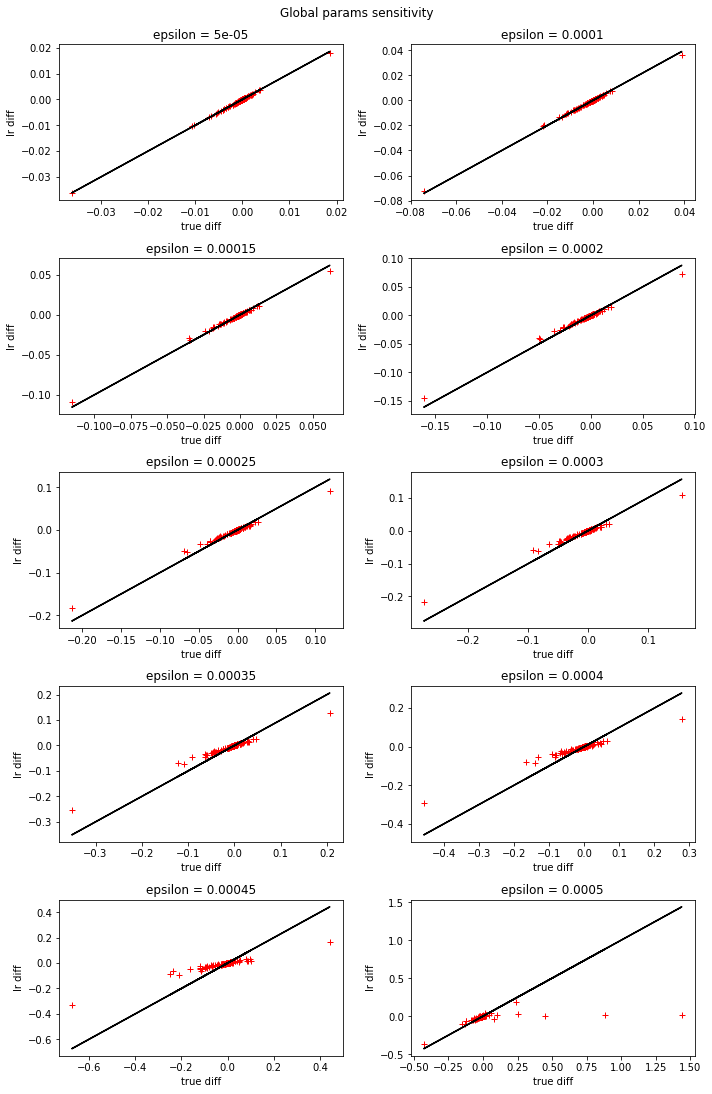

In [83]:
# check global params

# linear_sens.moment_model.set_moments_from_free_par(best_param)

# fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x))

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list2[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


(0.0, 0.0005200000000000001)

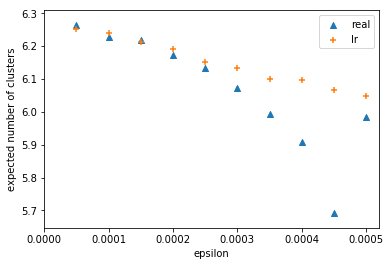

In [84]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list2[i])
    
    lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.xlim((0.0, epsilons[-1]+0.00002))